In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
from yahooquery import Ticker
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib as plt
import math
from pandas.tseries.offsets import DateOffset

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

import warnings

warnings.filterwarnings("ignore")

In [2]:
class DataLoader:
    supportedLists = ["russell1000", "russell3000", "snp500", "allUSstocks"]
    loadedSources = dict([(key, None) for key in supportedLists])

    df = None

    def __init__(self, List):
        if List not in self.supportedLists:
            raise Exception(f"currently supported lists: {self.supportedLists}")

        self.List = List

        if self.loadedSources[List] is None:
            functionName = "self." + "load_" + List + "()"
            self.df = eval(functionName)
            self.loadedSources[List] = self.df.copy()
        else:
            self.df = self.loadedSources[List].copy()

    def load_testSet(self, symbols):
        df = self.load_russell3000()

        df = df[df["symbol"].isin(symbols)]

        return df

    def load_russell1000(self):
        source = pd.read_html("https://en.wikipedia.org/wiki/Russell_1000_Index")
        df = source[2].copy()
        df = df.rename(columns={"Ticker": "symbol", "GICS Sector": "sector"})
        df = df.filter(items=["symbol", "sector"])

        return df

    def load_russell3000(self):
        source = pd.read_html(
            "http://www.kibot.com/Historical_Data/Russell_3000_Historical_Intraday_Data.aspx"
        )
        df = source[1].copy()
        header = df.iloc[0]  # grab the first row for the header
        df = df[1:]  # take the data less the header row
        df.columns = header  # set the header row as the df header
        df = df.rename(
            columns={"Symbol": "symbol", "Sector": "sector", "Industry": "industry"}
        )
        df = df.filter(items=["symbol", "industry", "sector"])

        return df

    def load_snp500(self):
        source = pd.read_html(
            "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
        )
        df = source[0].copy()
        df = df.rename(columns={"Symbol": "symbol", "GICS Sector": "sector"})
        df = df.filter(items=["symbol", "sector"])

        return df

    def load_allUSstocks(self):
        source = pd.read_csv("us_symbols.csv")
        df = source.copy()

        return df


# Usage
# L = DataLoader('snp500')
# df_test = L.df.iloc[0:3].copy()
# df_test

In [3]:
def ProcessIncomeStatementHistory(symbols):
    data = Ticker(symbols).all_modules

    out_df = pd.DataFrame()

    for s in symbols:
        try:
            temp_data = data[s]["incomeStatementHistoryQuarterly"][
                "incomeStatementHistory"
            ]
            if len(temp_data) == 0:
                continue
        except:
            continue

        temp_df = pd.DataFrame(temp_data)

        # Clean up dataframe
        temp_df["symbol"] = s
        temp_df["date"] = pd.to_datetime(temp_df["endDate"], format="%Y-%m-%d")
        temp_df = temp_df.filter(
            items=[
                "symbol",
                "date",
                "totalRevenue",
                "costOfRevenue",
                "grossProfit",
                "totalOperatingExpenses",
                "operatingIncome",
                "netIncome",
            ]
        )

        # Create period level features
        temp_df = temp_df.sort_values(by=["date"], ascending=False)
        temp_df["period"] = temp_df.apply(lambda row: (row.name + 1) * -1.0, axis=1)

        # Normalize features based on 'netIncome'
        features = [
            "totalRevenue",
            "costOfRevenue",
            "grossProfit",
            "totalOperatingExpenses",
            "operatingIncome",
        ]
        for feature in features:
            try:
                temp_df[feature] = temp_df.apply(
                    lambda row: (row[feature] / row["netIncome"]), axis=1
                )
            except:
                temp_df[feature] = np.nan

        # Create trend features
        for feature in features:
            key = f"{feature}_trend"
            temp_df[key] = temp_df[feature] - temp_df[feature].shift(-1)
        temp_df = temp_df.drop(columns=["netIncome"])

        out_df = out_df.append(temp_df, ignore_index=True)

    return out_df


# Usage:
ProcessIncomeStatementHistory(["TXG", "AAPL"])

,symbol,date,totalRevenue,costOfRevenue,grossProfit,totalOperatingExpenses,operatingIncome,period,totalRevenue_trend,costOfRevenue_trend,grossProfit_trend,totalOperatingExpenses_trend,operatingIncome_trend
0,TXG,2022-12-31,-9.075341,-2.156666,-6.918676,-10.660935,1.585594,-1.0,-5.948176,-1.439077,-4.509099,-6.679736,0.731560
1,TXG,2022-09-30,-3.127165,-0.717588,-2.409577,-3.981200,0.854034,-2.0,-1.349124,-0.287789,-1.061334,-1.223962,-0.125161
2,TXG,2022-06-30,-1.778042,-0.429799,-1.348242,-2.757237,0.979196,-3.0,0.921508,0.170913,0.750595,0.926327,-0.004819
3,TXG,2022-03-31,-2.699550,-0.600712,-2.098838,-3.683564,0.984014,-4.0,NaN,NaN,NaN,NaN,NaN
4,AAPL,2022-12-31,3.905394,2.227549,1.677845,2.704780,1.200613,-1.0,-0.445072,-0.284444,-0.160628,-0.444295,-0.000777
5,AAPL,2022-09-24,4.350466,2.511993,1.838473,3.149076,1.201390,-2.0,0.083466,0.090740,-0.007273,0.068991,0.014475
6,AAPL,2022-06-25,4.266999,2.421253,1.845746,3.080084,1.186915,-3.0,0.377435,0.233368,0.144067,0.389201,-0.011766
7,AAPL,2022-03-26,3.889564,2.187885,1.701679,2.690884,1.198681,-4.0,NaN,NaN,NaN,NaN,NaN


In [4]:
def ProcessGradingHistory(symbols):
    data = Ticker(symbols).grading_history
    data = data.reset_index(drop=True)

    # Clean up date features
    data["epochGradeDate"] = data["epochGradeDate"].apply(lambda x: x[0:10])
    data["date"] = pd.to_datetime(data["epochGradeDate"], format="%Y-%m-%d")

    # Create action feature
    actions = ["main", "reit", "down", "up", "init"]
    for action in actions:
        data[action] = data["action"].apply(lambda x: 1 if x == action else 0)
    data = data.filter(items=["symbol", "date", "main", "reit", "down", "up", "init"])

    data["period"] = np.nan

    return data


# Usage:
ProcessGradingHistory(["TXG", "AAPL"]).head()

,date,main,reit,down,up,init,period
0,2023-03-31,0,0,0,0,1,NaN
1,2023-02-16,1,0,0,0,0,NaN
2,2023-02-16,1,0,0,0,0,NaN
3,2023-02-16,1,0,0,0,0,NaN
4,2023-02-02,0,0,0,0,1,NaN


In [5]:
def ProcessEarningHistory(symbols):
    out_df = pd.DataFrame()

    for s in symbols:
        temp = None  # Ensure this variable is cleared
        temp = Ticker(s)
        temp_df = None  # Ensure this variable is cleared
        temp_df = temp.earning_history.reset_index().copy()

        out_df = out_df.append(temp_df, ignore_index=True)

    bad_symbols = set(out_df[out_df["surprisePercent"] == {}]["symbol"])
    out_df = out_df[~out_df["symbol"].isin(bad_symbols)]

    out_df = out_df.rename(columns={"quarter": "date"})
    out_df["date"] = pd.to_datetime(out_df["date"], format="%Y-%m-%d")
    out_df["period"] = out_df["period"].apply(lambda x: float(x.replace("q", "")))

    # Create new features
    out_df["surpriseBinary"] = out_df["epsDifference"].apply(
        lambda x: 1 if float(x) > 0 else 0
    )

    out_df = out_df.filter(
        items=[
            "symbol",
            "epsActual",
            "epsEstimate",
            "epsDifference",
            "surprisePercent",
            "date",
            "period",
            "surpriseBinary",
        ]
    )

    return out_df


# Usage
ProcessEarningHistory(["TXG", "AAPL"])

,symbol,epsActual,epsEstimate,epsDifference,surprisePercent,date,period,surpriseBinary
0,TXG,-0.38,-0.31,-0.07,-0.226,2022-03-31,-4.0,0
1,TXG,-0.57,-0.39,-0.18,-0.462,2022-06-30,-3.0,0
2,TXG,-0.37,-0.46,0.09,0.196,2022-09-30,-2.0,1
3,TXG,-0.15,-0.31,0.16,0.516,2022-12-31,-1.0,1
4,AAPL,1.52,1.43,0.09,0.063,2022-03-31,-4.0,1
5,AAPL,1.20,1.16,0.04,0.034,2022-06-30,-3.0,1
6,AAPL,1.29,1.27,0.02,0.016,2022-09-30,-2.0,1
7,AAPL,1.88,1.94,-0.06,-0.031,2022-12-31,-1.0,0


In [6]:
class TimeChopper:
    FinalDf = None

    def __init__(self, Symbols, EarningHistory, IncomeStatementHistory, GradingHistory):
        self.Symbols = Symbols
        self.EarningHistory = EarningHistory
        self.IncomeStatementHistory = IncomeStatementHistory
        self.GradingHistory = GradingHistory

    def createDataset(self, NumQuarters, Delay):
        out_df = pd.DataFrame()

        for symbol in set(self.Symbols["symbol"]):
            r = {}

            # Add symbol
            r["symbol"] = symbol

            # Add sector
            sector_name = self.Symbols[self.Symbols["symbol"] == symbol]["sector"].iloc[
                0
            ]
            r["sector"] = sector_name

            # EarningHistory
            EarningHistory = self.EarningHistory[
                self.EarningHistory["symbol"] == symbol
            ].copy()
            EarningHistory = EarningHistory.sort_values(by=["period"], ascending=False)

            # Create target
            if Delay != -1:
                try:
                    r["target"] = EarningHistory["surpriseBinary"].iloc[Delay]
                except:
                    continue

                # Identify the 'as_of_date' and 'max_history_date'
                as_of_date = EarningHistory["date"].iloc[Delay]
                as_of_period = EarningHistory["period"].iloc[Delay]
                key = NumQuarters + Delay
                max_history_date = EarningHistory["date"].iloc[key]
                max_history_period = EarningHistory["period"].iloc[key]
            else:
                as_of_period = 0
                try:
                    max_history_period = EarningHistory["period"].iloc[
                        (NumQuarters - 1)
                    ]
                    as_of_date = pd.to_datetime("today").date()
                    max_history_date = as_of_date - DateOffset(months=(3 * NumQuarters))
                except:
                    continue

            # EarningHistory is filtered by period
            EarningHistory = EarningHistory[
                (EarningHistory["period"] < as_of_period)
                & (EarningHistory["period"] >= max_history_period)
            ]
            EarningHistoryFeatures = [
                col
                for col in EarningHistory.columns
                if col not in ["symbol", "period", "date"]
            ]

            # Period features
            for period in range(0, EarningHistory.shape[0]):
                for feature in EarningHistoryFeatures:
                    r[f"company_period_{period}_{feature}"] = EarningHistory.iloc[
                        period
                    ][feature]

            # Company level features
            for feature in EarningHistoryFeatures:
                r[f"company_mean_{feature}"] = EarningHistory[feature].mean()
                r[f"company_median_{feature}"] = EarningHistory[feature].median()
                r[f"company_max_{feature}"] = EarningHistory[feature].max()
                r[f"company_min_{feature}"] = EarningHistory[feature].min()

            # IncomeStatementHistory is fileted by period
            IncomeStatementHistory = self.IncomeStatementHistory[
                self.IncomeStatementHistory["symbol"] == symbol
            ].copy()
            IncomeStatementHistory = IncomeStatementHistory.sort_values(
                by=["period"], ascending=False
            )
            IncomeStatementHistory = IncomeStatementHistory[
                (IncomeStatementHistory["period"] < as_of_period)
                & (IncomeStatementHistory["period"] >= max_history_period)
            ]
            IncomeStatementHistoryFeatures = [
                col
                for col in IncomeStatementHistory.columns
                if col not in ["symbol", "period", "date"]
            ]

            for period in range(0, IncomeStatementHistory.shape[0]):
                for feature in IncomeStatementHistoryFeatures:
                    r[
                        f"company_period_{period}_{feature}"
                    ] = IncomeStatementHistory.iloc[period][feature]

            # Company level features
            for feature in IncomeStatementHistoryFeatures:
                r[f"company_mean_{feature}"] = IncomeStatementHistory[feature].mean()
                r[f"company_median_{feature}"] = IncomeStatementHistory[
                    feature
                ].median()
                r[f"company_max_{feature}"] = IncomeStatementHistory[feature].max()
                r[f"company_min_{feature}"] = IncomeStatementHistory[feature].min()

            # Grading history
            GradingHistory = self.GradingHistory[
                self.GradingHistory["symbol"] == symbol
            ].copy()
            GradingHistory = GradingHistory.sort_values(by=["period"], ascending=False)
            GradingHistory = GradingHistory[
                (GradingHistory["date"] < np.datetime64(as_of_date))
                & (GradingHistory["date"] >= np.datetime64(max_history_date))
            ]

            GradingHistory = (
                GradingHistory.groupby("symbol").sum().reset_index(drop=True)
            )

            GradingActions = ["main", "reit", "down", "up", "init"]
            for action in GradingActions:
                try:
                    r[f"action_{action}_sum"] = GradingHistory[action].iloc[0]
                except:
                    r[f"action_{action}_sum"] = 0

            out_df = out_df.append(r, ignore_index=True)

        # Fill sector one hot values
        # sectorCols = [col for col in out_df if col.startswith('in_sector_')]
        # for col in sectorCols:
        #    out_df[col] = out_df[col].fillna(0)

        sector_out = pd.DataFrame()

        for sector in set(self.Symbols["sector"]):
            r = {}
            r["sector"] = sector

            SectorDf = out_df[out_df["sector"] == sector].copy()
            SectorDfFeatures = [
                col for col in SectorDf if col not in ["symbol", "sector", "target"]
            ]
            for feature in SectorDfFeatures:
                r[f"sector_mean_{feature}"] = SectorDf[feature].mean()
                r[f"sector_median_{feature}"] = SectorDf[feature].median()
                r[f"sector_max_{feature}"] = SectorDf[feature].max()
                r[f"sector_min_{feature}"] = SectorDf[feature].min()

            sector_out = sector_out.append(r, ignore_index=True)

        SectorOneHot = pd.get_dummies(sector_out["sector"], drop_first=False)
        sector_out = pd.merge(
            sector_out,
            SectorOneHot.add_prefix("in_sector_"),
            how="left",
            left_index=True,
            right_index=True,
        )

        final_out = out_df.merge(sector_out, left_on="sector", right_on="sector")
        final_out = final_out.drop(columns=["sector"])

        self.FinalDf = final_out

        return self.FinalDf


# Usage
# L = DataLoader('snp500')
# Symbols = L.df.iloc[0:3].copy()
# t = TimeChopper(Symbols=Symbols,
#                EarningHistory=ProcessEarningHistory(Symbols['symbol']),
#                IncomeStatementHistory=ProcessIncomeStatementHistory(Symbols['symbol']),
#                GradingHistory=ProcessGradingHistory(Symbols['symbol']),
#                NumQuarters=2,
#                Delay=1)
# t.createDataset()

## Model training

In [7]:
L = DataLoader("russell3000")
Symbols = L.df.copy()
EarningHistory = ProcessEarningHistory(Symbols["symbol"])
IncomeStatementHistory = ProcessIncomeStatementHistory(Symbols["symbol"])
GradingHistory = ProcessEarningHistory(Symbols["symbol"])

In [8]:
# snp500 runtime: 292.9s
# russell1000 runtime: 969.7s
# russell3000 runtime:
t = TimeChopper(
    Symbols=Symbols,
    EarningHistory=EarningHistory,
    IncomeStatementHistory=IncomeStatementHistory,
    GradingHistory=GradingHistory,
)

In [9]:
X_train = t.createDataset(NumQuarters=2, Delay=1)

In [10]:
X_train.head()

,symbol,target,company_period_0_epsActual,company_period_0_epsEstimate,company_period_0_epsDifference,company_period_0_surprisePercent,company_period_0_surpriseBinary,company_period_1_epsActual,company_period_1_epsEstimate,company_period_1_epsDifference,company_period_1_surprisePercent,company_period_1_surpriseBinary,company_mean_epsActual,company_median_epsActual,company_max_epsActual,company_min_epsActual,company_mean_epsEstimate,company_median_epsEstimate,company_max_epsEstimate,company_min_epsEstimate,company_mean_epsDifference,company_median_epsDifference,company_max_epsDifference,company_min_epsDifference,company_mean_surprisePercent,company_median_surprisePercent,company_max_surprisePercent,company_min_surprisePercent,company_mean_surpriseBinary,company_median_surpriseBinary,company_max_surpriseBinary,company_min_surpriseBinary,company_period_0_totalRevenue,company_period_0_costOfRevenue,company_period_0_grossProfit,company_period_0_totalOperatingExpenses,company_period_0_operatingIncome,company_period_0_totalRevenue_trend,company_period_0_costOfRevenue_trend,company_period_0_grossProfit_trend,company_period_0_totalOperatingExpenses_trend,company_period_0_operatingIncome_trend,company_period_1_totalRevenue,company_period_1_costOfRevenue,company_period_1_grossProfit,company_period_1_totalOperatingExpenses,company_period_1_operatingIncome,company_period_1_totalRevenue_trend,company_period_1_costOfRevenue_trend,company_period_1_grossProfit_trend,company_period_1_totalOperatingExpenses_trend,company_period_1_operatingIncome_trend,company_mean_totalRevenue,company_median_totalRevenue,company_max_totalRevenue,company_min_totalRevenue,company_mean_costOfRevenue,company_median_costOfRevenue,company_max_costOfRevenue,company_min_costOfRevenue,company_mean_grossProfit,company_median_grossProfit,company_max_grossProfit,company_min_grossProfit,company_mean_totalOperatingExpenses,company_median_totalOperatingExpenses,company_max_totalOperatingExpenses,company_min_totalOperatingExpenses,company_mean_operatingIncome,company_median_operatingIncome,company_max_operatingIncome,company_min_operatingIncome,company_mean_totalRevenue_trend,company_median_totalRevenue_trend,company_max_totalRevenue_trend,company_min_totalRevenue_trend,company_mean_costOfRevenue_trend,company_median_costOfRevenue_trend,company_max_costOfRevenue_trend,company_min_costOfRevenue_trend,company_mean_grossProfit_trend,company_median_grossProfit_trend,company_max_grossProfit_trend,company_min_grossProfit_trend,company_mean_totalOperatingExpenses_trend,company_median_totalOperatingExpenses_trend,company_max_totalOperatingExpenses_trend,company_min_totalOperatingExpenses_trend,company_mean_operatingIncome_trend,company_median_operatingIncome_trend,company_max_operatingIncome_trend,company_min_operatingIncome_trend,action_main_sum,action_reit_sum,action_down_sum,action_up_sum,action_init_sum,sector_mean_company_period_0_epsActual,sector_median_company_period_0_epsActual,sector_max_company_period_0_epsActual,sector_min_company_period_0_epsActual,sector_mean_company_period_0_epsEstimate,sector_median_company_period_0_epsEstimate,sector_max_company_period_0_epsEstimate,sector_min_company_period_0_epsEstimate,sector_mean_company_period_0_epsDifference,sector_median_company_period_0_epsDifference,sector_max_company_period_0_epsDifference,sector_min_company_period_0_epsDifference,sector_mean_company_period_0_surprisePercent,sector_median_company_period_0_surprisePercent,sector_max_company_period_0_surprisePercent,sector_min_company_period_0_surprisePercent,sector_mean_company_period_0_surpriseBinary,sector_median_company_period_0_surpriseBinary,sector_max_company_period_0_surpriseBinary,sector_min_company_period_0_surpriseBinary,sector_mean_company_period_1_epsActual,sector_median_company_period_1_epsActual,sector_max_company_period_1_epsActual,sector_min_company_period_1_epsActual,sector_mean_company_period_1_epsEstimate,sector_median_company_period_1_epsEstimate,sector_max_

(2167, 490)
1.0


,symbol,yhat_proba,y
1642,HCP,1.0,1
1732,FICO,1.0,1
1151,SKY,1.0,1
1810,LFUS,1.0,1
1782,PAYC,1.0,1
1588,TEL,1.0,1
1390,GPI,1.0,1
1730,SANM,1.0,1
1076,LEA,1.0,1
638,CHE,1.0,1


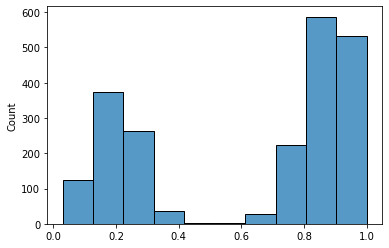

In [11]:
# Lets make a simple model
y_train = X_train["target"]
X_train = X_train.fillna(0)
print(X_train.shape)

clf = RandomForestClassifier(random_state=13).fit(
    X_train.drop(columns=["symbol", "target"]), y_train
)
yhat_train_proba = clf.predict_proba(X_train.drop(columns=["symbol", "target"]))[:, 1]
sns.histplot(data=yhat_train_proba, bins=10)

results = pd.DataFrame()
results["symbol"] = X_train["symbol"]
results["yhat_proba"] = yhat_train_proba
results["y"] = y_train
print(clf.score(X_train.drop(columns=["symbol", "target"]), y_train))
results.sort_values(by=["yhat_proba"], ascending=False).head(10)

In [12]:
feature_names = X_train.drop(columns=["symbol", "target"]).columns
w = clf.feature_importances_
feature_importance = pd.DataFrame(feature_names, columns=["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

# sns.barplot(data=feature_importance, x="importance", y="feature",color='steelblue')
feature_importance.head(15)

,feature,importance
3,company_period_0_surprisePercent,1.021309
25,company_min_surprisePercent,1.020620
21,company_min_epsDifference,1.018576
23,company_median_surprisePercent,1.018506
2,company_period_0_epsDifference,1.017655
18,company_mean_epsDifference,1.017164
22,company_mean_surprisePercent,1.016904
8,company_period_1_surprisePercent,1.016606
24,company_max_surprisePercent,1.016421
19,company_median_epsDifference,1.015096


# Test

In [13]:
X_test = t.createDataset(NumQuarters=2, Delay=0)

(2167, 490)
0.6248269497000462


,symbol,yhat_proba,y
967,HOG,0.97,1
1839,DIOD,0.97,1
1730,SANM,0.97,1
400,CBT,0.95,1
471,TKR,0.95,1
318,CB,0.95,0
514,SON,0.94,1
508,THO,0.94,1
1076,LEA,0.94,1
615,VHI,0.94,0


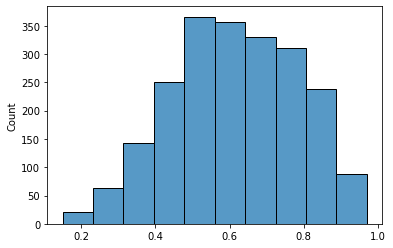

In [14]:
y_test = X_test["target"]
X_test = X_test.fillna(0)
print(X_test.shape)

yhat_test_proba = clf.predict_proba(X_test.drop(columns=["symbol", "target"]))[:, 1]
sns.histplot(data=yhat_test_proba, bins=10)

results = pd.DataFrame()
results["symbol"] = X_test[
    "symbol"
]  # mdf_test[mdf_test['as_of_date'] >= pd.Timestamp(2022, 12, 15)].symbol
results["yhat_proba"] = yhat_test_proba
results["y"] = y_test
print(clf.score(X_test.drop(columns=["symbol", "target"]), y_test))
results.sort_values(by=["yhat_proba"], ascending=False).head(10)

## DEBUG

In [15]:
X_future = t.createDataset(NumQuarters=2, Delay=-1)

In [16]:
X_future.head()

,symbol,company_period_0_epsActual,company_period_0_epsEstimate,company_period_0_epsDifference,company_period_0_surprisePercent,company_period_0_surpriseBinary,company_period_1_epsActual,company_period_1_epsEstimate,company_period_1_epsDifference,company_period_1_surprisePercent,company_period_1_surpriseBinary,company_mean_epsActual,company_median_epsActual,company_max_epsActual,company_min_epsActual,company_mean_epsEstimate,company_median_epsEstimate,company_max_epsEstimate,company_min_epsEstimate,company_mean_epsDifference,company_median_epsDifference,company_max_epsDifference,company_min_epsDifference,company_mean_surprisePercent,company_median_surprisePercent,company_max_surprisePercent,company_min_surprisePercent,company_mean_surpriseBinary,company_median_surpriseBinary,company_max_surpriseBinary,company_min_surpriseBinary,company_period_0_totalRevenue,company_period_0_costOfRevenue,company_period_0_grossProfit,company_period_0_totalOperatingExpenses,company_period_0_operatingIncome,company_period_0_totalRevenue_trend,company_period_0_costOfRevenue_trend,company_period_0_grossProfit_trend,company_period_0_totalOperatingExpenses_trend,company_period_0_operatingIncome_trend,company_period_1_totalRevenue,company_period_1_costOfRevenue,company_period_1_grossProfit,company_period_1_totalOperatingExpenses,company_period_1_operatingIncome,company_period_1_totalRevenue_trend,company_period_1_costOfRevenue_trend,company_period_1_grossProfit_trend,company_period_1_totalOperatingExpenses_trend,company_period_1_operatingIncome_trend,company_mean_totalRevenue,company_median_totalRevenue,company_max_totalRevenue,company_min_totalRevenue,company_mean_costOfRevenue,company_median_costOfRevenue,company_max_costOfRevenue,company_min_costOfRevenue,company_mean_grossProfit,company_median_grossProfit,company_max_grossProfit,company_min_grossProfit,company_mean_totalOperatingExpenses,company_median_totalOperatingExpenses,company_max_totalOperatingExpenses,company_min_totalOperatingExpenses,company_mean_operatingIncome,company_median_operatingIncome,company_max_operatingIncome,company_min_operatingIncome,company_mean_totalRevenue_trend,company_median_totalRevenue_trend,company_max_totalRevenue_trend,company_min_totalRevenue_trend,company_mean_costOfRevenue_trend,company_median_costOfRevenue_trend,company_max_costOfRevenue_trend,company_min_costOfRevenue_trend,company_mean_grossProfit_trend,company_median_grossProfit_trend,company_max_grossProfit_trend,company_min_grossProfit_trend,company_mean_totalOperatingExpenses_trend,company_median_totalOperatingExpenses_trend,company_max_totalOperatingExpenses_trend,company_min_totalOperatingExpenses_trend,company_mean_operatingIncome_trend,company_median_operatingIncome_trend,company_max_operatingIncome_trend,company_min_operatingIncome_trend,action_main_sum,action_reit_sum,action_down_sum,action_up_sum,action_init_sum,sector_mean_company_period_0_epsActual,sector_median_company_period_0_epsActual,sector_max_company_period_0_epsActual,sector_min_company_period_0_epsActual,sector_mean_company_period_0_epsEstimate,sector_median_company_period_0_epsEstimate,sector_max_company_period_0_epsEstimate,sector_min_company_period_0_epsEstimate,sector_mean_company_period_0_epsDifference,sector_median_company_period_0_epsDifference,sector_max_company_period_0_epsDifference,sector_min_company_period_0_epsDifference,sector_mean_company_period_0_surprisePercent,sector_median_company_period_0_surprisePercent,sector_max_company_period_0_surprisePercent,sector_min_company_period_0_surprisePercent,sector_mean_company_period_0_surpriseBinary,sector_median_company_period_0_surpriseBinary,sector_max_company_period_0_surpriseBinary,sector_min_company_period_0_surpriseBinary,sector_mean_company_period_1_epsActual,sector_median_company_period_1_epsActual,sector_max_company_period_1_epsActual,sector_min_company_period_1_epsActual,sector_mean_company_period_1_epsEstimate,sector_median_company_period_1_epsEstimate,sector_max_company

In [17]:
date_str = "2023apr03"
X_train.to_csv(f"matrices/X_train_{date_str}.csv", index=False)
y_train.to_csv(f"matrices/y_train_{date_str}.csv", index=False)
X_test.to_csv(f"matrices/X_test_{date_str}.csv", index=False)
y_test.to_csv(f"matrices/y_test_{date_str}.csv", index=False)
X_future.to_csv(f"matrices/X_future_{date_str}.csv", index=False)

## Futuresight Test

,symbol,yhat_proba
436,SNA,0.96
171,TEX,0.94
115,GRMN,0.93
721,ALSN,0.93
67,FTV,0.92
1517,DIOD,0.92
319,TPH,0.92
233,AIT,0.91
138,BLD,0.91
264,MGRC,0.91


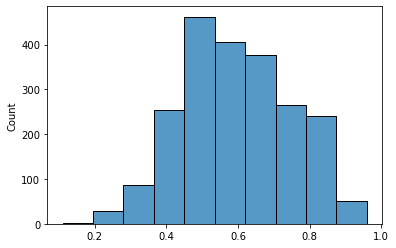

In [357]:
X_future = X_future.fillna(0)
# X_future = X_future.drop(columns=[x for x in list(X_future.columns) if x not in list(X_train.columns)])
yhat_future_proba = clf.predict_proba(X_future.drop(columns=["symbol"]))[:, 1]
sns.histplot(data=yhat_future_proba, bins=10)

results = pd.DataFrame()
results["symbol"] = X_future[
    "symbol"
]  # mdf_test[mdf_test['as_of_date'] >= pd.Timestamp(2022, 12, 15)].symbol
results["yhat_proba"] = yhat_future_proba
# results['y'] = y_test
# print(clf.score(X_test.drop(columns=['symbol']),y_test))
results.sort_values(by=["yhat_proba"], ascending=False).head(65)

In [2]:
import pickle

with open("results/experiment_results2023mar28.pkl", "rb") as f:
    t = pickle.load(f)

In [24]:
df.head(10)

,params,mean_test_p@65,mean_test_p@195
684,"{'NONE|RF__RF__max_depth': 50, 'NONE|RF__RF__m...",0.953846,0.815385
16956,"{'STANDARD|RF__RF__max_depth': None, 'STANDARD...",0.953846,0.815385
17106,"{'STANDARD|RF__RF__max_depth': 50, 'STANDARD|R...",0.953846,0.815385
17136,"{'STANDARD|RF__RF__max_depth': 100, 'STANDARD|...",0.953846,0.815385
534,"{'NONE|RF__RF__max_depth': None, 'NONE|RF__RF_...",0.953846,0.815385
714,"{'NONE|RF__RF__max_depth': 100, 'NONE|RF__RF__...",0.953846,0.815385
20975,"{'STANDARD|XGB__XGB__learning_rate': 0.6, 'STA...",0.938462,0.769231
18525,"{'STANDARD|XGB__XGB__learning_rate': 0.6, 'STA...",0.938462,0.769231
23425,"{'STANDARD|XGB__XGB__learning_rate': 0.6, 'STA...",0.938462,0.769231
419,"{'NONE|RF__RF__max_depth': 20, 'NONE|RF__RF__m...",0.923077,0.825641


In [22]:
df = (
    t.sort_values(by=["mean_test_p@65"], ascending=False)
    .filter(items=["params", "mean_test_p@65", "mean_test_p@195"])
    .head(10)
    .copy()
)

df["params"].iloc[9]

{'NONE|RF__RF__max_depth': 20,
 'NONE|RF__RF__max_features': 'sqrt',
 'NONE|RF__RF__min_samples_split': 2,
 'NONE|RF__RF__n_estimators': 100,
 'NONE|RF__RF__random_state': 3421126067,
 'est_name': 'NONE|RF'}

In [26]:
df2 = (
    t.sort_values(by=["mean_test_p@195"], ascending=False)
    .filter(items=["params", "mean_test_p@65", "mean_test_p@195"])
    .head(10)
    .copy()
)

df2["params"].iloc[0]

{'NONE|RF__RF__max_depth': 1,
 'NONE|RF__RF__max_features': 'log2',
 'NONE|RF__RF__min_samples_split': 5,
 'NONE|RF__RF__n_estimators': 100,
 'NONE|RF__RF__random_state': 4083286876,
 'est_name': 'NONE|RF'}

In [33]:
df2.head(10)

,params,mean_test_p@65,mean_test_p@195
559,"{'NONE|RF__RF__max_depth': 1, 'NONE|RF__RF__ma...",0.830769,0.876923
554,"{'NONE|RF__RF__max_depth': 1, 'NONE|RF__RF__ma...",0.830769,0.876923
16981,"{'STANDARD|RF__RF__max_depth': 1, 'STANDARD|RF...",0.830769,0.876923
16986,"{'STANDARD|RF__RF__max_depth': 1, 'STANDARD|RF...",0.830769,0.876923
16976,"{'STANDARD|RF__RF__max_depth': 1, 'STANDARD|RF...",0.830769,0.876923
564,"{'NONE|RF__RF__max_depth': 1, 'NONE|RF__RF__ma...",0.830769,0.876923
24496,"{'STANDARD|MLP__MLP__activation': 'logistic', ...",0.861538,0.866667
8776,"{'MINMAX|RF__RF__max_depth': 1, 'MINMAX|RF__RF...",0.892308,0.861538
560,"{'NONE|RF__RF__max_depth': 1, 'NONE|RF__RF__ma...",0.892308,0.861538
8771,"{'MINMAX|RF__RF__max_depth': 1, 'MINMAX|RF__RF...",0.892308,0.861538


In [44]:
X_test = pd.read_csv("matrices/X_test_2023mar28.csv").drop(columns="Unnamed: 0")
y_test = pd.read_csv("matrices/y_test_2023mar28.csv").drop(columns="Unnamed: 0")

0.9990779160903642


,symbol,yhat_proba,y
1741,RPD,1.000000,1.0
1227,IART,1.000000,1.0
532,BLDR,0.995461,1.0
2160,ESE,0.990000,1.0
1627,LSCC,0.990000,1.0
1752,UTI,0.990000,1.0
1585,FIVN,0.990000,1.0
1284,WAT,0.988990,1.0
1308,PKI,0.988990,1.0
143,LECO,0.988513,1.0


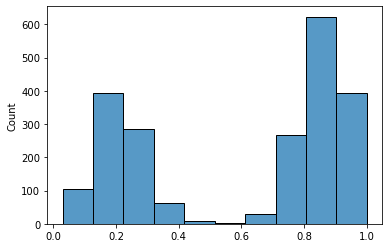

In [57]:
# Lets make a simply model
clf = RandomForestClassifier(
    random_state=13, max_depth=20, max_features=2, min_samples_split=2, n_estimators=100
).fit(X_test.drop(columns=["symbol", "target"]), y_test)
yhat_test_proba = clf.predict_proba(X_test.drop(columns=["symbol", "target"]))[:, 1]
sns.histplot(data=yhat_test_proba, bins=10)

results = pd.DataFrame()
results["symbol"] = X_test["symbol"]
results["yhat_proba"] = yhat_test_proba
results["y"] = y_test
print(clf.score(X_test.drop(columns=["symbol", "target"]), y_test))
results.sort_values(by=["yhat_proba"], ascending=False).head(10)

In [58]:
feature_names = X_test.drop(columns=["symbol", "target"]).columns
w = clf.feature_importances_
feature_importance = pd.DataFrame(feature_names, columns=["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

# sns.barplot(data=feature_importance, x="importance", y="feature",color='steelblue')
feature_importance.tail(15)

,feature,importance
98,action_down_sum,1.0
244,sector_min_company_min_surpriseBinary,1.0
239,sector_max_company_max_surpriseBinary,1.0
10,company_period_1_index,1.0
215,sector_max_company_mean_index,1.0
216,sector_min_company_mean_index,1.0
217,sector_mean_company_median_index,1.0
144,sector_min_company_period_1_index,1.0
28,company_mean_index,1.0
218,sector_median_company_median_index,1.0


In [63]:
X_test.head()

,symbol,target,company_period_0_epsActual,company_period_0_epsEstimate,company_period_0_epsDifference,company_period_0_surprisePercent,company_period_0_index,company_period_0_surpriseBinary,company_period_1_epsActual,company_period_1_epsEstimate,company_period_1_epsDifference,company_period_1_surprisePercent,company_period_1_index,company_period_1_surpriseBinary,company_mean_epsActual,company_median_epsActual,company_max_epsActual,company_min_epsActual,company_mean_epsEstimate,company_median_epsEstimate,company_max_epsEstimate,company_min_epsEstimate,company_mean_epsDifference,company_median_epsDifference,company_max_epsDifference,company_min_epsDifference,company_mean_surprisePercent,company_median_surprisePercent,company_max_surprisePercent,company_min_surprisePercent,company_mean_index,company_median_index,company_max_index,company_min_index,company_mean_surpriseBinary,company_median_surpriseBinary,company_max_surpriseBinary,company_min_surpriseBinary,company_period_0_totalRevenue,company_period_0_costOfRevenue,company_period_0_grossProfit,company_period_0_totalOperatingExpenses,company_period_0_operatingIncome,company_period_0_totalRevenue_trend,company_period_0_costOfRevenue_trend,company_period_0_grossProfit_trend,company_period_0_totalOperatingExpenses_trend,company_period_0_operatingIncome_trend,company_period_1_totalRevenue,company_period_1_costOfRevenue,company_period_1_grossProfit,company_period_1_totalOperatingExpenses,company_period_1_operatingIncome,company_period_1_totalRevenue_trend,company_period_1_costOfRevenue_trend,company_period_1_grossProfit_trend,company_period_1_totalOperatingExpenses_trend,company_period_1_operatingIncome_trend,company_mean_totalRevenue,company_median_totalRevenue,company_max_totalRevenue,company_min_totalRevenue,company_mean_costOfRevenue,company_median_costOfRevenue,company_max_costOfRevenue,company_min_costOfRevenue,company_mean_grossProfit,company_median_grossProfit,company_max_grossProfit,company_min_grossProfit,company_mean_totalOperatingExpenses,company_median_totalOperatingExpenses,company_max_totalOperatingExpenses,company_min_totalOperatingExpenses,company_mean_operatingIncome,company_median_operatingIncome,company_max_operatingIncome,company_min_operatingIncome,company_mean_totalRevenue_trend,company_median_totalRevenue_trend,company_max_totalRevenue_trend,company_min_totalRevenue_trend,company_mean_costOfRevenue_trend,company_median_costOfRevenue_trend,company_max_costOfRevenue_trend,company_min_costOfRevenue_trend,company_mean_grossProfit_trend,company_median_grossProfit_trend,company_max_grossProfit_trend,company_min_grossProfit_trend,company_mean_totalOperatingExpenses_trend,company_median_totalOperatingExpenses_trend,company_max_totalOperatingExpenses_trend,company_min_totalOperatingExpenses_trend,company_mean_operatingIncome_trend,company_median_operatingIncome_trend,company_max_operatingIncome_trend,company_min_operatingIncome_trend,action_main_sum,action_reit_sum,action_down_sum,action_up_sum,action_init_sum,sector_mean_company_period_0_epsActual,sector_median_company_period_0_epsActual,sector_max_company_period_0_epsActual,sector_min_company_period_0_epsActual,sector_mean_company_period_0_epsEstimate,sector_median_company_period_0_epsEstimate,sector_max_company_period_0_epsEstimate,sector_min_company_period_0_epsEstimate,sector_mean_company_period_0_epsDifference,sector_median_company_period_0_epsDifference,sector_max_company_period_0_epsDifference,sector_min_company_period_0_epsDifference,sector_mean_company_period_0_surprisePercent,sector_median_company_period_0_surprisePercent,sector_max_company_period_0_surprisePercent,sector_min_company_period_0_surprisePercent,sector_mean_company_period_0_index,sector_median_company_period_0_index,sector_max_company_period_0_index,sector_min_company_period_0_index,sector_mean_company_period_0_surpriseBinary,sector_median_company_period_0_surpriseBinary,sector_max_company_period_0_surpriseBinary,sector_min_company_period_0_surp

In [59]:
X_future = pd.read_csv("matrices/X_future_2023mar28.csv").drop(columns="Unnamed: 0")

,symbol,yhat_proba
1846,PSIX,0.970000
1796,CAE,0.910000
2136,MGPI,0.890000
1425,MEDP,0.870000
1364,MRK,0.870000
1501,PAYC,0.863135
1826,DOLE,0.860000
1831,BOOM,0.860000
1288,HSIC,0.859679
1862,OTTR,0.859167


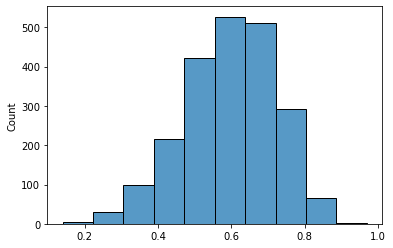

In [61]:
X_future = X_future.fillna(0)

yhat_future_proba = clf.predict_proba(X_future.drop(columns=["symbol"]))[:, 1]
sns.histplot(data=yhat_future_proba, bins=10)

results = pd.DataFrame()
results["symbol"] = X_test["symbol"]
results["yhat_proba"] = yhat_future_proba
# results['y'] = y_test
# print(clf.score(X_test.drop(columns=['symbol','target']),y_test))
results.sort_values(by=["yhat_proba"], ascending=False).head(65)